### About Dataset
Uncover the factors that lead to employee attrition and explore important questions such as ‘show me a breakdown of distance from home by job role and attrition’ or ‘compare average monthly income by education and attrition’. This is a fictional data set created by IBM data scientists.

Education =
1 : 'Below College'
2 :'College'
3 :'Bachelor'
4 :'Master'
5 :'Doctor'

Environment Satisfaction=
1 :'Low'
2 :'Medium'
3 :'High'
4 :'Very High'

Job Involvement=
1 :'Low'
2 :'Medium'
3 :'High'
4 :'Very High'

Job Satisfaction=
1 :'Low'
2 :'Medium'
3 :'High'
4 :'Very High'

Performance Rating=
1 :'Low'
2 :'Good'
3 :'Excellent'
4 :'Outstanding'

Relationship Satisfaction=
1 :'Low'
2 :'Medium'
3 :'High'
4 :'Very High'

Work Life Balance=
1 :'Bad'
2 :'Good'
3 :'Better'
4 :'Best'

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, classification_report
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import pickle

In [3]:
df = pd.read_csv("HR-Employee-Attrition.csv")

# 1. Average weekly working hours
# Most employees work 40 hours, but some work more.
df["avg_weekly_hours"] = np.random.normal(loc=42, scale=5, size=len(df)).astype(int)


# 2. Annual leave days
# Normally around 14–25 days, may be slightly less for younger employees
df["annual_leave_days"] = np.random.randint(10, 26, size=len(df))

# 3. Job satisfaction survey score (1–10)
# Overall distribution will be at a moderate level
df["satisfaction_score"] = np.random.normal(loc=6, scale=2, size=len(df))
df["satisfaction_score"] = df["satisfaction_score"].clip(1, 10).round()

# 4. Final performance score (1–5)
# We distribute scores mostly around 3–4.
df["performance_score"] = np.random.choice([1,2,3,4,5], size=len(df), p=[0.05,0.1,0.45,0.3,0.1])

# 5. Extra: Burnout risk (synthetic feature to support the target variable)
# Long working hours + few days off + low satisfaction → high burnout
df["burnout_risk"] = (
    (df["avg_weekly_hours"] > 48).astype(int) +
    (df["annual_leave_days"] < 12).astype(int) +
    (df["satisfaction_score"] < 4).astype(int)
)

# Let's normalize burnout risk to 0–2
df["burnout_risk"] = df["burnout_risk"].clip(0, 2)

# Let's look at the first 10 rows of the new dataset
print(df.head(10))

# To save
df.to_csv("extended_hr_dataset.csv", index=False)

   Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   
5   32        No  Travel_Frequently       1005  Research & Development   
6   59        No      Travel_Rarely       1324  Research & Development   
7   30        No      Travel_Rarely       1358  Research & Development   
8   38        No  Travel_Frequently        216  Research & Development   
9   36        No      Travel_Rarely       1299  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8      

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       1470 non-null   int64  
 1   Attrition                 1470 non-null   object 
 2   BusinessTravel            1470 non-null   object 
 3   DailyRate                 1470 non-null   int64  
 4   Department                1470 non-null   object 
 5   DistanceFromHome          1470 non-null   int64  
 6   Education                 1470 non-null   int64  
 7   EducationField            1470 non-null   object 
 8   EmployeeCount             1470 non-null   int64  
 9   EmployeeNumber            1470 non-null   int64  
 10  EnvironmentSatisfaction   1470 non-null   int64  
 11  Gender                    1470 non-null   object 
 12  HourlyRate                1470 non-null   int64  
 13  JobInvolvement            1470 non-null   int64  
 14  JobLevel

In [5]:
def clean_hr_dataset(df):
    """
    Cleans the HR dataset by removing all irrelevant or low-value columns.
    
    Explanation:
    - Some columns contain constant values (no variance), so they provide no useful information.
    - Some are IDs or artificial variables that don’t help prediction.
    - Others are redundant because we added more meaningful features.
    
   """
    
    
    drop_cols = [
        "EmployeeCount",     # Constant = 1 for all rows
        "Over18",            # Constant = 'Y' for all rows
        "StandardHours",     # Constant = 80 for all rows
        "EmployeeNumber",    # Employee ID, no predictive power
        "DailyRate",         # Randomized variable, low signal
        "HourlyRate",        # Randomized variable, low signal
        "MonthlyRate",       # Randomized variable, low signal
        "PerformanceRating"  # Low variance, replaced by performance_score
    ]
    
    
    df_clean = df.drop(columns=[col for col in drop_cols if col in df.columns])
    
    return df_clean



df = pd.read_csv("extended_hr_dataset.csv")
df_clean = clean_hr_dataset(df)

print("Original shape:", df.shape)
print("Cleaned shape:", df_clean.shape)
print("Remaining columns:", df_clean.columns.tolist())

Original shape: (1470, 40)
Cleaned shape: (1470, 32)
Remaining columns: ['Age', 'Attrition', 'BusinessTravel', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'avg_weekly_hours', 'annual_leave_days', 'satisfaction_score', 'performance_score', 'burnout_risk']


In [6]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       1470 non-null   int64  
 1   Attrition                 1470 non-null   object 
 2   BusinessTravel            1470 non-null   object 
 3   Department                1470 non-null   object 
 4   DistanceFromHome          1470 non-null   int64  
 5   Education                 1470 non-null   int64  
 6   EducationField            1470 non-null   object 
 7   EnvironmentSatisfaction   1470 non-null   int64  
 8   Gender                    1470 non-null   object 
 9   JobInvolvement            1470 non-null   int64  
 10  JobLevel                  1470 non-null   int64  
 11  JobRole                   1470 non-null   object 
 12  JobSatisfaction           1470 non-null   int64  
 13  MaritalStatus             1470 non-null   object 
 14  MonthlyI

In [7]:
df_clean.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,...,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,avg_weekly_hours,annual_leave_days,satisfaction_score,performance_score,burnout_risk
0,41,Yes,Travel_Rarely,Sales,1,2,Life Sciences,2,Female,3,...,1,6,4,0,5,39,11,9.0,3,1
1,49,No,Travel_Frequently,Research & Development,8,1,Life Sciences,3,Male,2,...,3,10,7,1,7,36,13,9.0,5,0
2,37,Yes,Travel_Rarely,Research & Development,2,2,Other,4,Male,2,...,3,0,0,0,0,34,19,5.0,4,0
3,33,No,Travel_Frequently,Research & Development,3,4,Life Sciences,4,Female,3,...,3,8,7,3,0,41,13,6.0,3,0
4,27,No,Travel_Rarely,Research & Development,2,1,Medical,1,Male,3,...,3,2,2,2,2,37,12,8.0,4,0


### Graphic Part 

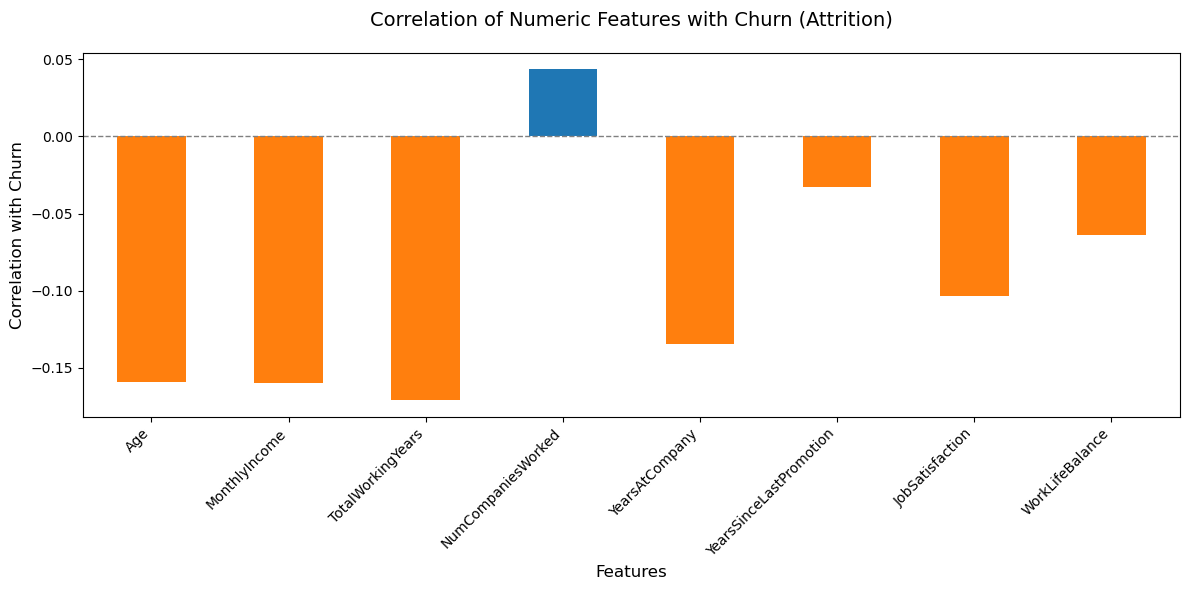

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

df_clean['Attrition'] = df_clean['Attrition'].map({"Yes": 1, "No": 0})

numeric_features = [
    "Age", "MonthlyIncome", "TotalWorkingYears", "NumCompaniesWorked",
    "YearsAtCompany", "YearsSinceLastPromotion", "JobSatisfaction",
    "WorkLifeBalance"
]


correlations = df_clean[numeric_features + ['Attrition']].corr()['Attrition'].drop('Attrition')


plt.figure(figsize=(12, 6))
correlations.plot(kind='bar', color=['#1f77b4' if x >= 0 else '#ff7f0e' for x in correlations])
plt.title('Correlation of Numeric Features with Churn (Attrition)', fontsize=14, pad=20)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Correlation with Churn', fontsize=12)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

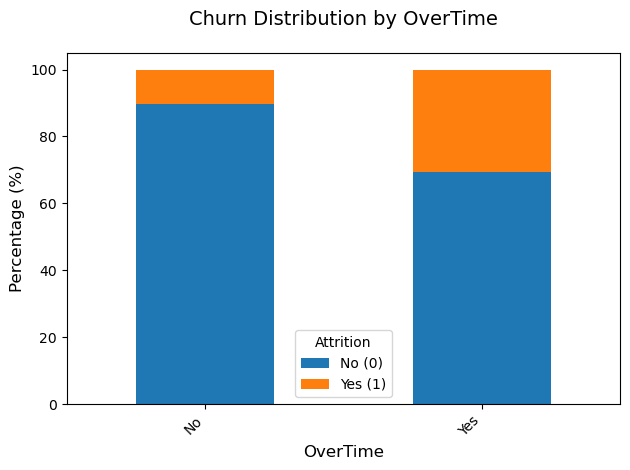

<Figure size 1200x600 with 0 Axes>

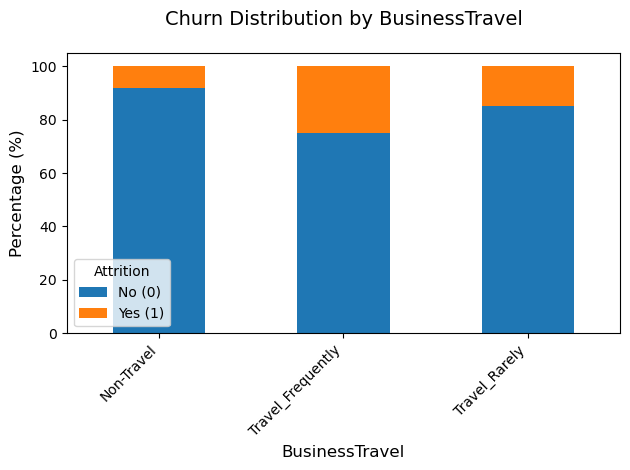

<Figure size 1200x600 with 0 Axes>

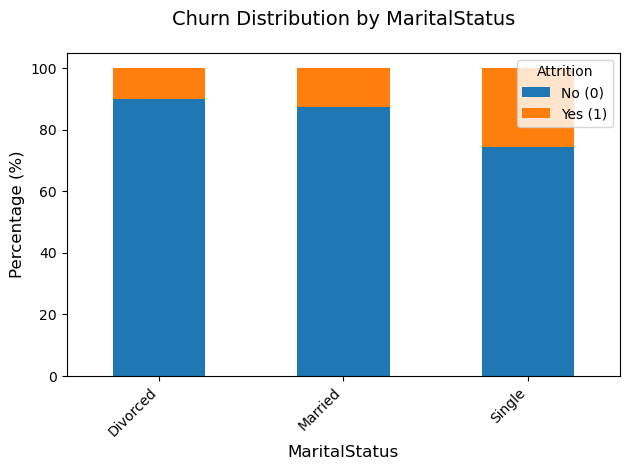

<Figure size 1200x600 with 0 Axes>

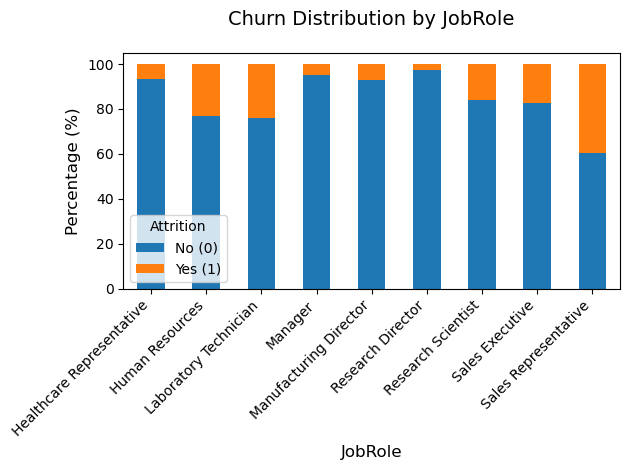

In [10]:
categorical_features = ["OverTime", "BusinessTravel", "MaritalStatus", "JobRole"]


for feature in categorical_features:
    plt.figure(figsize=(12, 6))
    crosstab = pd.crosstab(df_clean[feature], df_clean['Attrition'], normalize='index') * 100
    crosstab.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'])
    plt.title(f'Churn Distribution by {feature}', fontsize=14, pad=20)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.legend(title='Attrition', labels=['No (0)', 'Yes (1)'])
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

C:\Users\erenk\AppData\Local\Temp\ipykernel_38588\3682707001.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Attrition', y=feature, data=df_clean, palette=['#1f77b4', '#ff7f0e'])


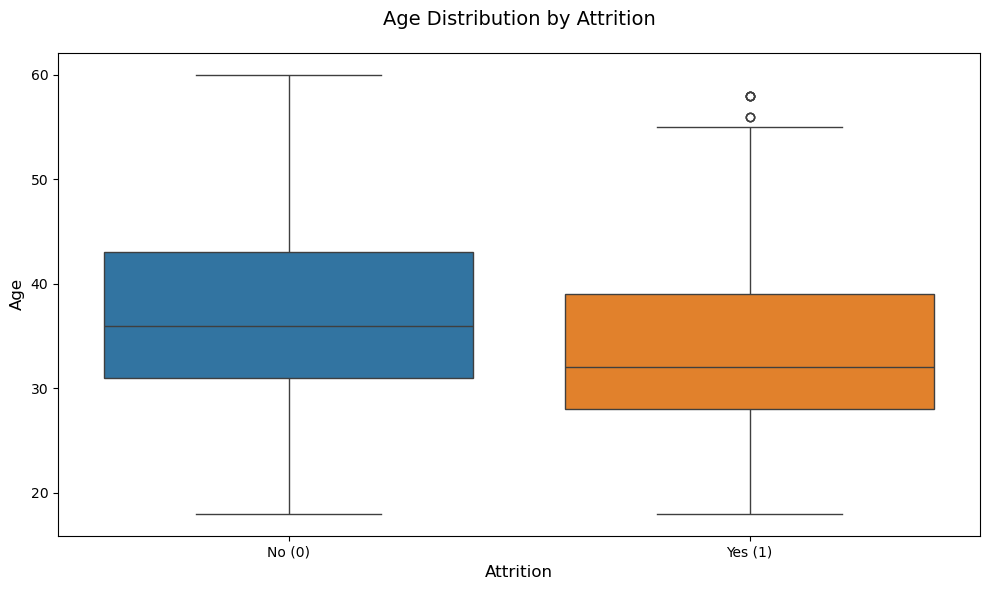

C:\Users\erenk\AppData\Local\Temp\ipykernel_38588\3682707001.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Attrition', y=feature, data=df_clean, palette=['#1f77b4', '#ff7f0e'])


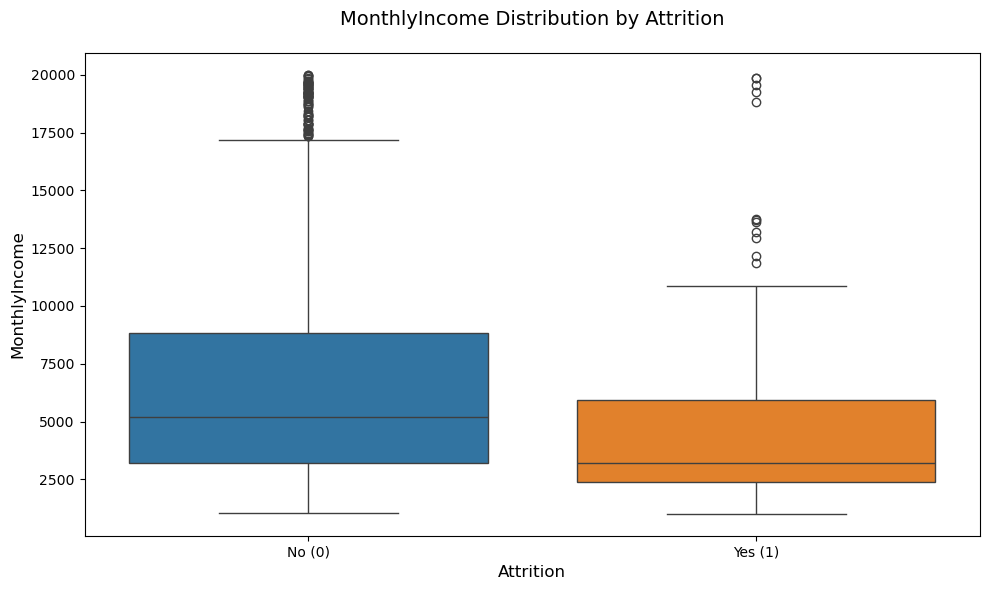

C:\Users\erenk\AppData\Local\Temp\ipykernel_38588\3682707001.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Attrition', y=feature, data=df_clean, palette=['#1f77b4', '#ff7f0e'])


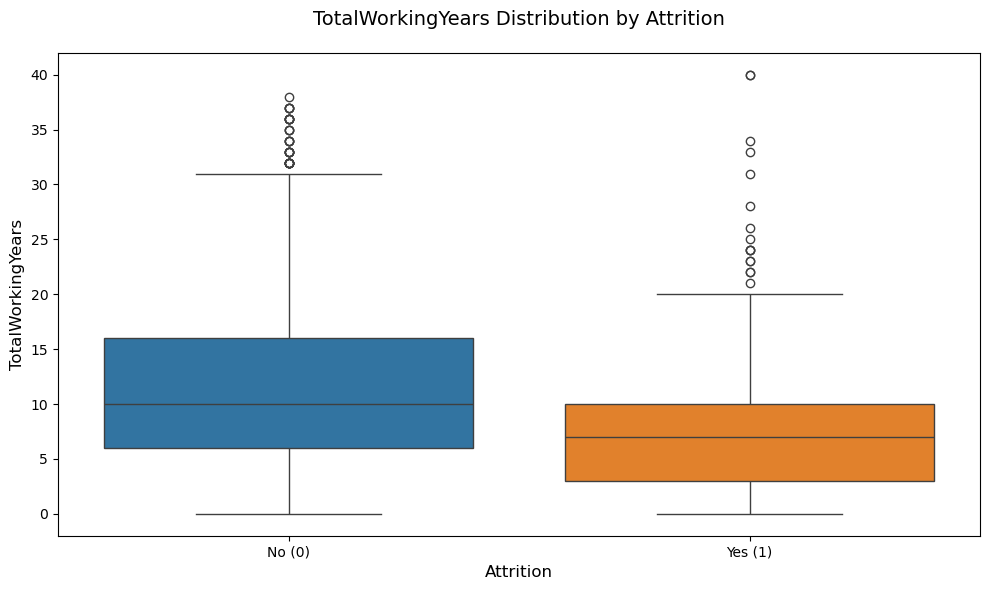

C:\Users\erenk\AppData\Local\Temp\ipykernel_38588\3682707001.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Attrition', y=feature, data=df_clean, palette=['#1f77b4', '#ff7f0e'])


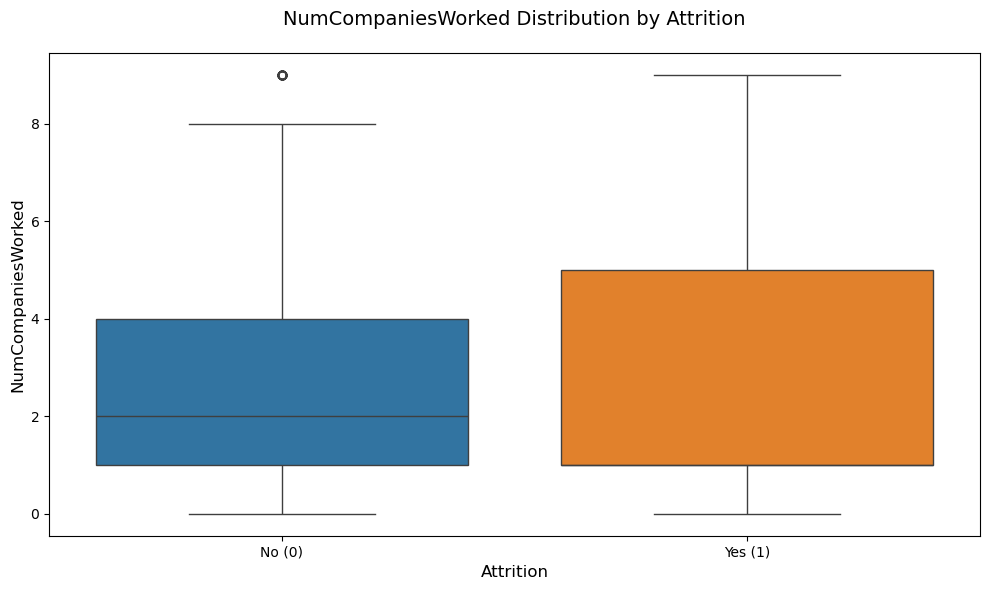

C:\Users\erenk\AppData\Local\Temp\ipykernel_38588\3682707001.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Attrition', y=feature, data=df_clean, palette=['#1f77b4', '#ff7f0e'])


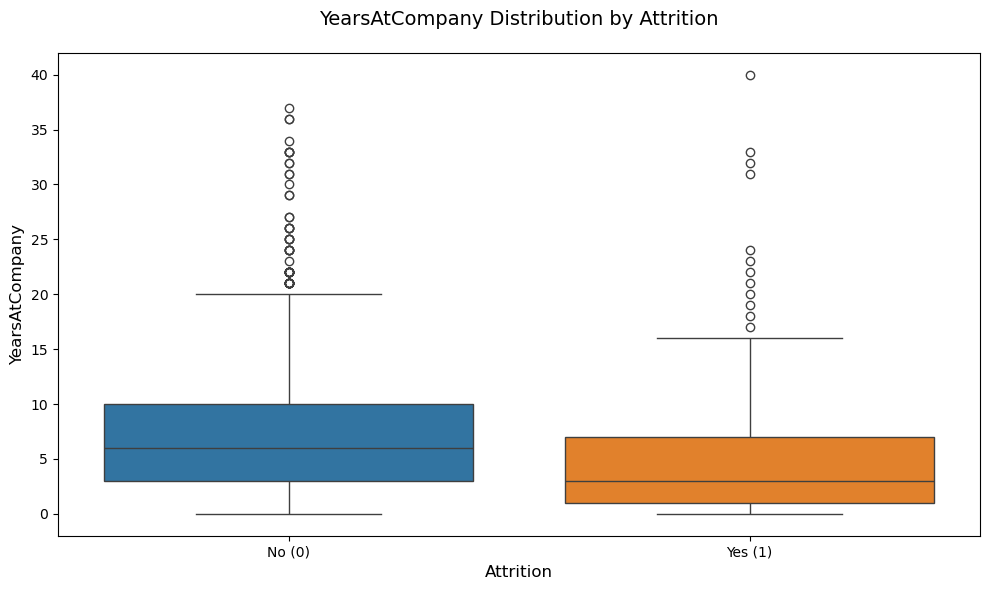

C:\Users\erenk\AppData\Local\Temp\ipykernel_38588\3682707001.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Attrition', y=feature, data=df_clean, palette=['#1f77b4', '#ff7f0e'])


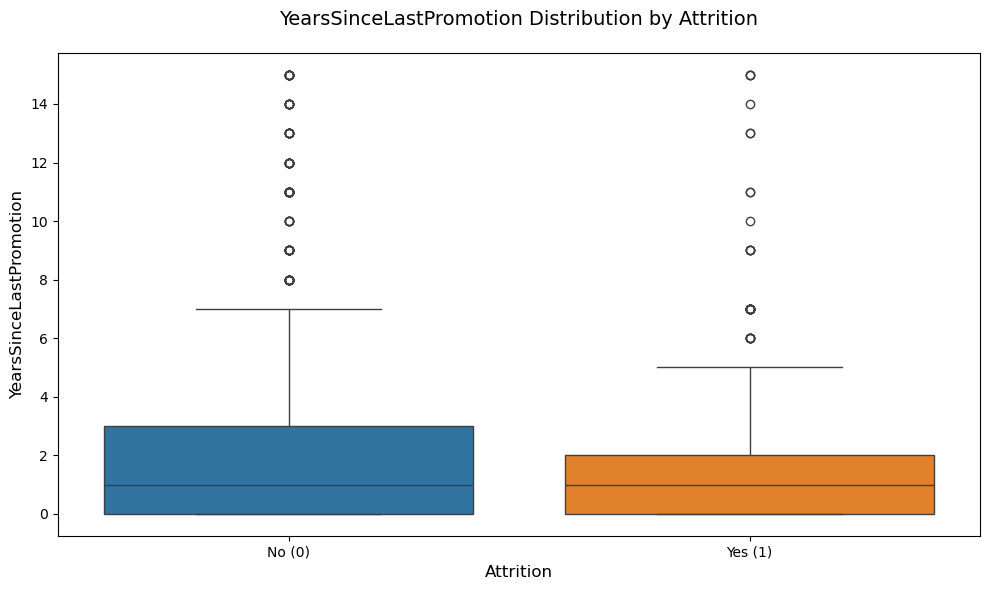

C:\Users\erenk\AppData\Local\Temp\ipykernel_38588\3682707001.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Attrition', y=feature, data=df_clean, palette=['#1f77b4', '#ff7f0e'])


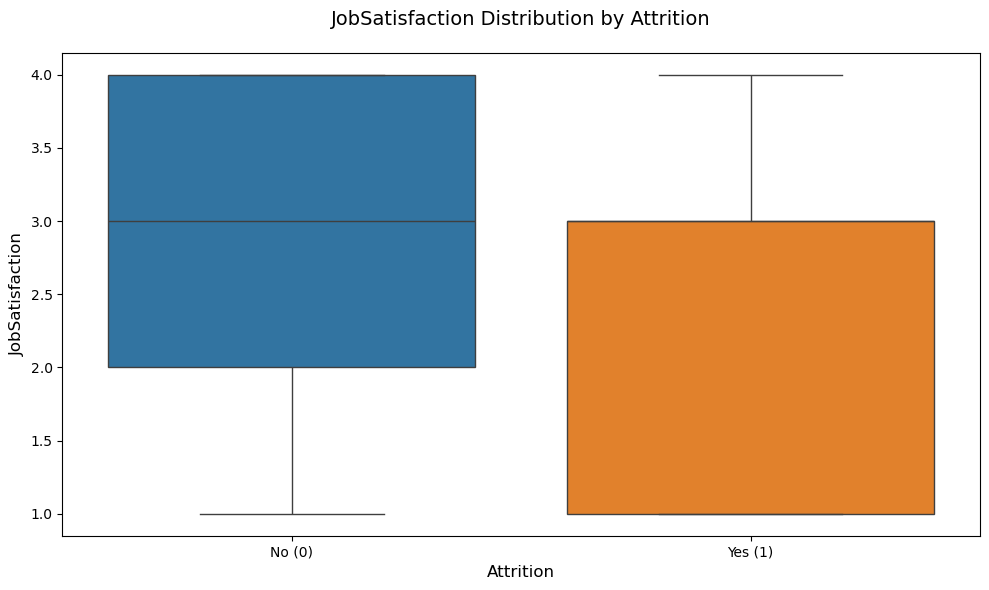

C:\Users\erenk\AppData\Local\Temp\ipykernel_38588\3682707001.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Attrition', y=feature, data=df_clean, palette=['#1f77b4', '#ff7f0e'])


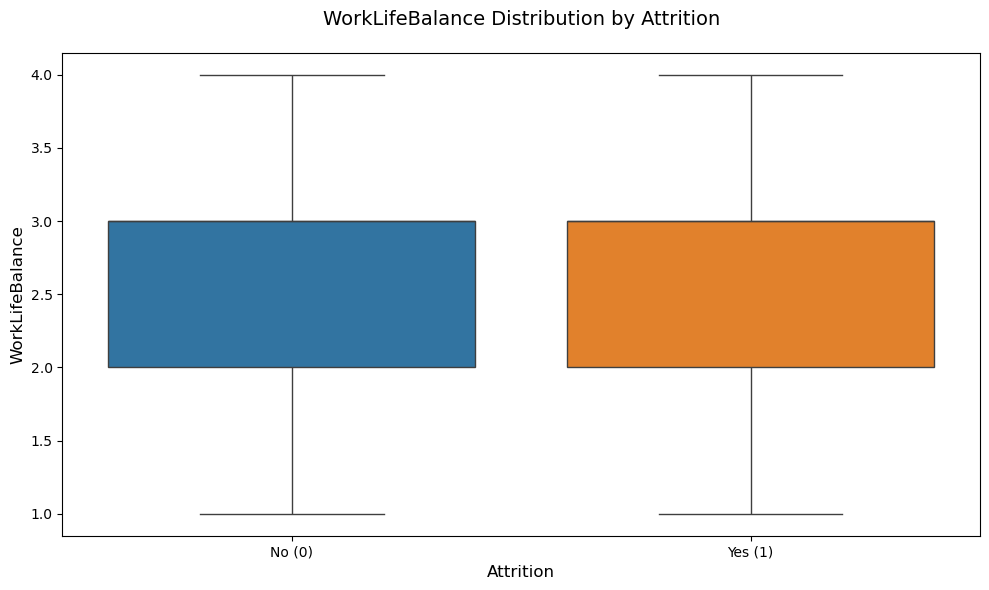

In [11]:

for feature in numeric_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Attrition', y=feature, data=df_clean, palette=['#1f77b4', '#ff7f0e'])
    plt.title(f'{feature} Distribution by Attrition', fontsize=14, pad=20)
    plt.xlabel('Attrition', fontsize=12)
    plt.ylabel(feature, fontsize=12)
    plt.xticks(ticks=[0, 1], labels=['No (0)', 'Yes (1)'])
    plt.tight_layout()
    plt.show()

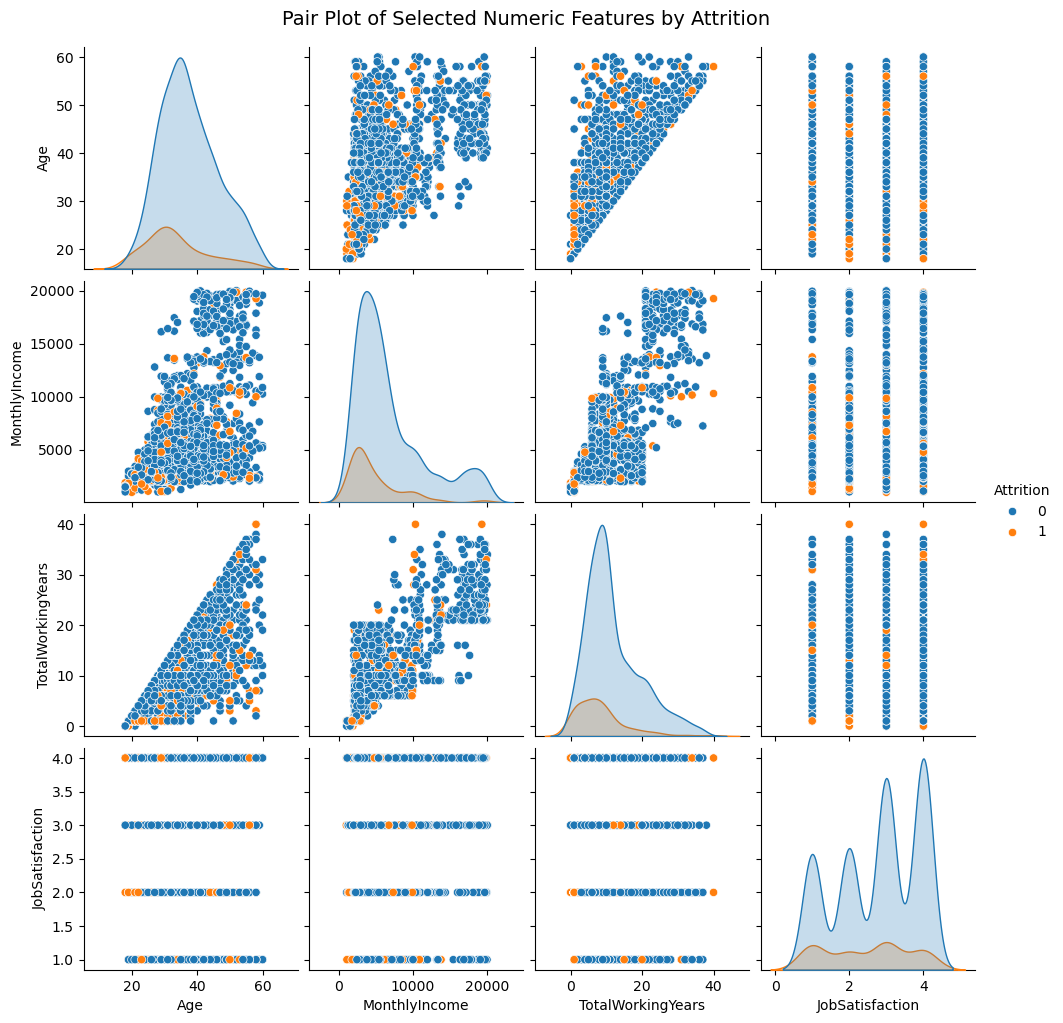

In [12]:
selected_features = ["Age", "MonthlyIncome", "TotalWorkingYears", "JobSatisfaction"]
sns.pairplot(df_clean, vars=selected_features, hue='Attrition', palette=['#1f77b4', '#ff7f0e'])
plt.suptitle('Pair Plot of Selected Numeric Features by Attrition', fontsize=14, y=1.02)
plt.show()

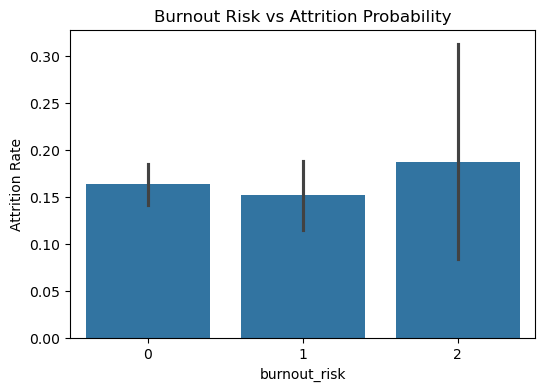

In [13]:
# Burnout risk vs attrition
plt.figure(figsize=(6,4))
sns.barplot(data=df_clean, x="burnout_risk", y=df["Attrition"].map({"Yes":1, "No":0}))
plt.title("Burnout Risk vs Attrition Probability")
plt.ylabel("Attrition Rate")
plt.show()

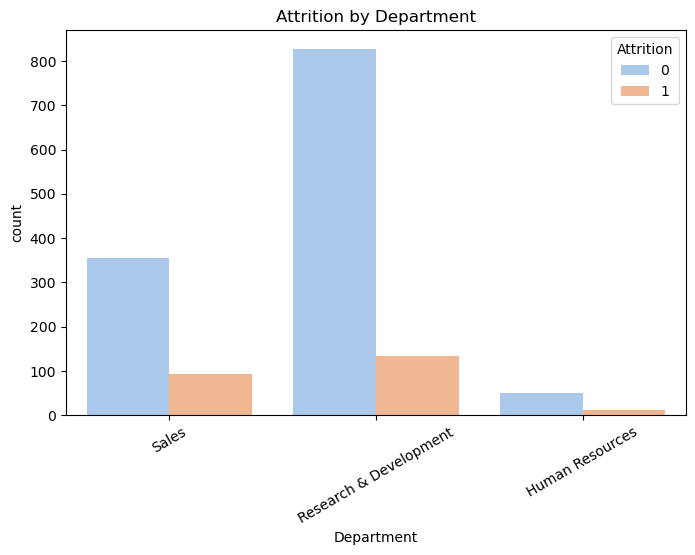

In [14]:
# Attrition by Department
plt.figure(figsize=(8,5))
sns.countplot(data=df_clean, x="Department", hue="Attrition", palette="pastel")
plt.title("Attrition by Department")
plt.xticks(rotation=30)
plt.show()

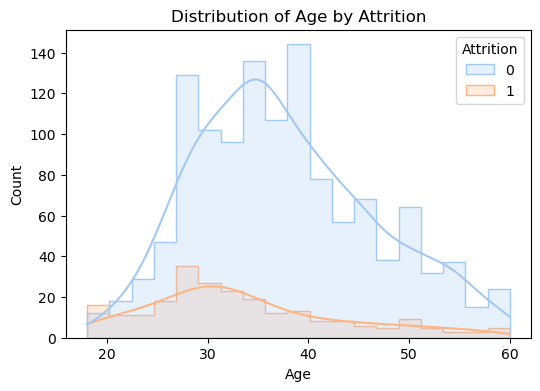

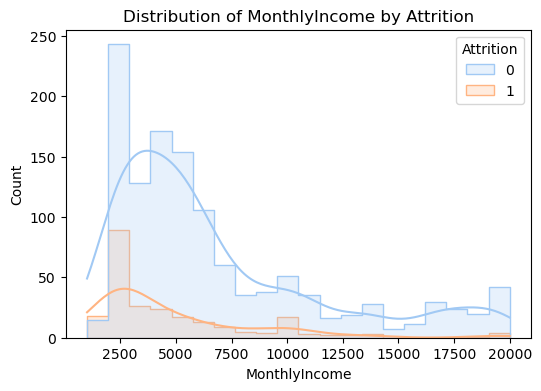

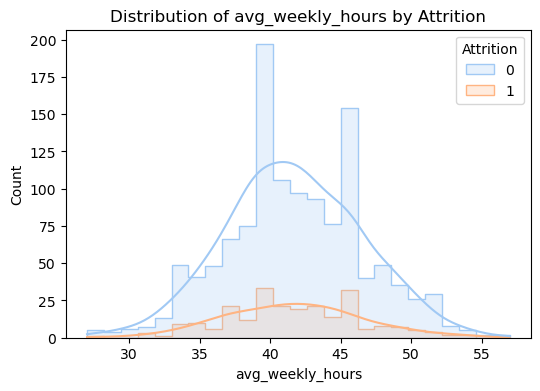

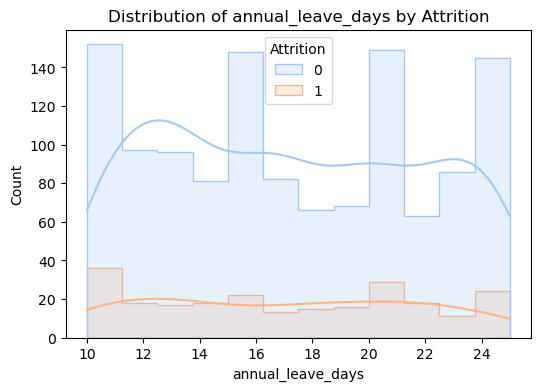

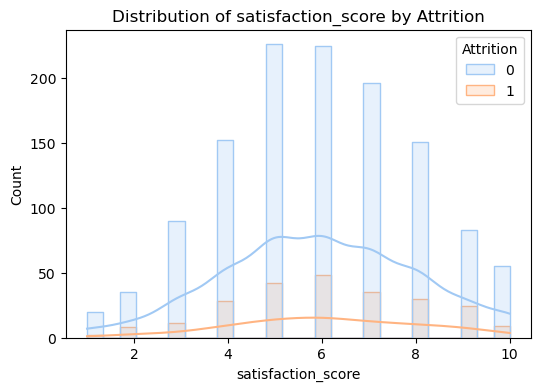

In [15]:
# Distribution of numeric features
numeric_features = ["Age", "MonthlyIncome", "avg_weekly_hours", "annual_leave_days", "satisfaction_score"]

for col in numeric_features:
    plt.figure(figsize=(6,4))
    sns.histplot(data=df_clean, x=col, kde=True, hue="Attrition", element="step", palette="pastel")
    plt.title(f"Distribution of {col} by Attrition")
    plt.show()

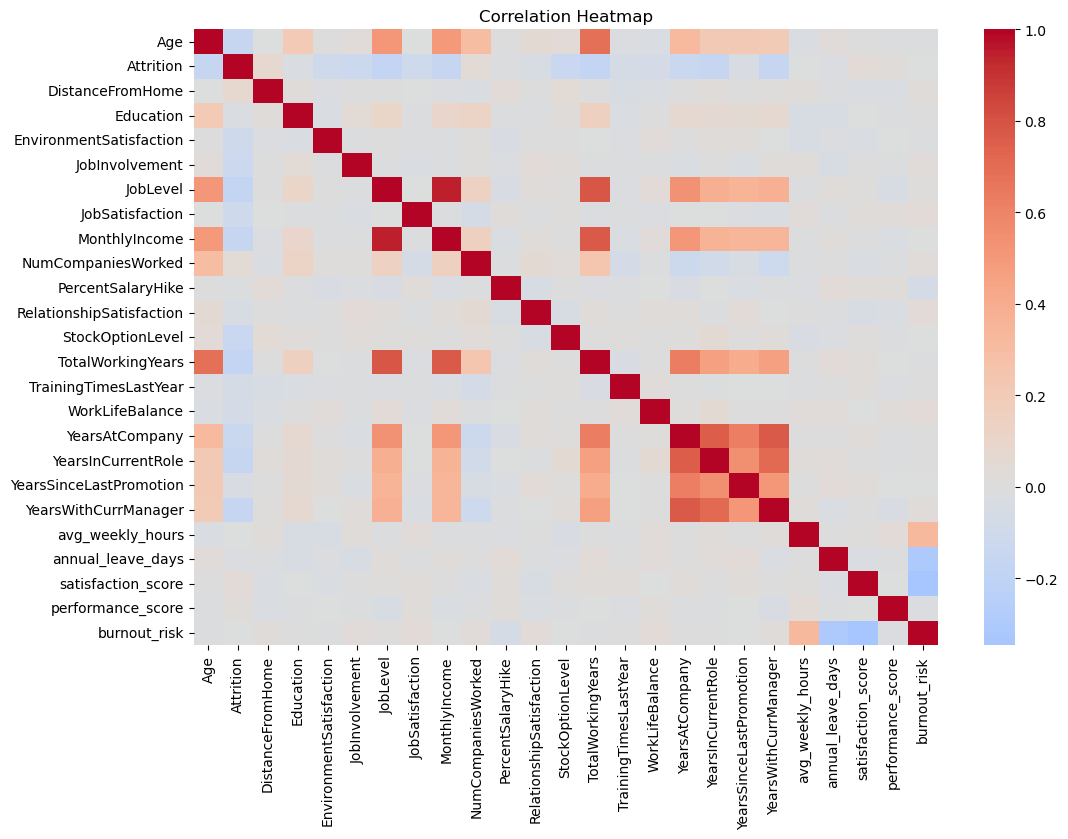

In [16]:
# Correlation heatmap (numerical features only)
plt.figure(figsize=(12,8))
corr = df_clean.select_dtypes(include=["int64","float64"]).corr()
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Correlation Heatmap")
plt.show()

## Model


Top 10 Important Features:
                         Feature  Coefficient  Importance
                     OverTime_No    -0.822013    0.822013
                    OverTime_Yes     0.820971    0.820971
   JobRole_Laboratory Technician     0.743475    0.743475
            MaritalStatus_Single     0.677671    0.677671
                 JobSatisfaction    -0.610674    0.610674
BusinessTravel_Travel_Frequently     0.609092    0.609092
         YearsSinceLastPromotion     0.603834    0.603834
              NumCompaniesWorked     0.551058    0.551058
               TotalWorkingYears    -0.538996    0.538996
              YearsInCurrentRole    -0.530399    0.530399

OverTime_Yes Importance:
     Feature  Coefficient  Importance
OverTime_Yes     0.820971    0.820971

MonthlyIncome Importance:
      Feature  Coefficient  Importance
MonthlyIncome    -0.211116    0.211116

Burnout Risk Importance:
     Feature  Coefficient  Importance
burnout_risk    -0.019743    0.019743


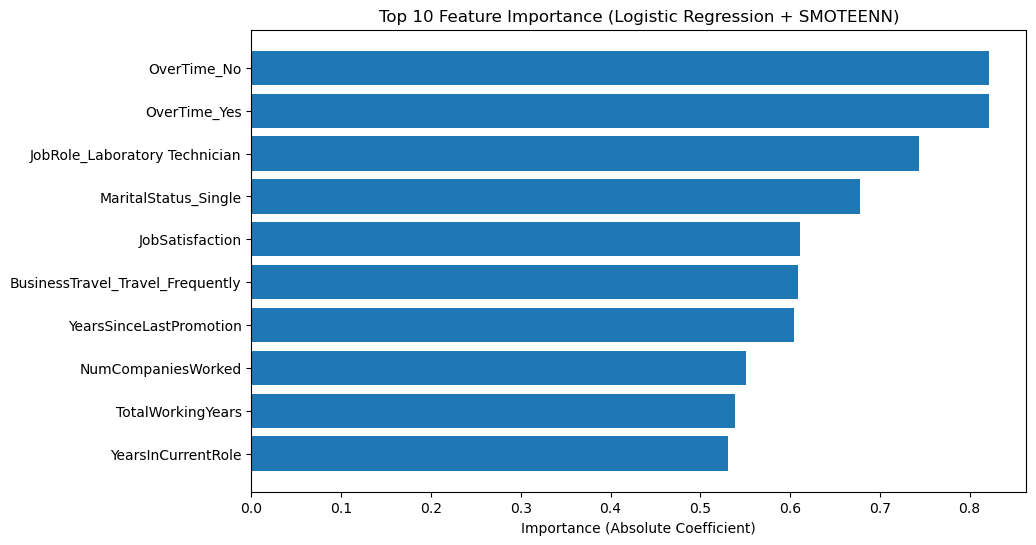


Classification Report with Custom Threshold (0.66):

              precision    recall  f1-score   support

           0       0.93      0.85      0.89       247
           1       0.45      0.64      0.53        47

    accuracy                           0.82       294
   macro avg       0.69      0.75      0.71       294
weighted avg       0.85      0.82      0.83       294


Risk Table saved as employee_risk_smoteenn.csv
 EmployeeID  Age  MonthlyIncome  TotalWorkingYears  NumCompaniesWorked  YearsAtCompany OverTime  YearsSinceLastPromotion BusinessTravel MaritalStatus                JobRole  JobSatisfaction  WorkLifeBalance  Attrition_True  Risk_Score  Prediction
       1061   24           2033                  1                   1               1       No                        0     Non-Travel       Married   Sales Representative                2                3               0    0.381955           0
        891   44           2011                 10                   1       

In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, classification_report
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import pickle

# Data Splitting
y = df_clean["Attrition"]
X = df_clean.drop(columns=["Attrition"])

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Columns: Numeric and Categorical
numeric_features = [
    "Age", "DistanceFromHome", "MonthlyIncome", "NumCompaniesWorked",
    "PercentSalaryHike", "TotalWorkingYears", "TrainingTimesLastYear",
    "YearsAtCompany", "YearsInCurrentRole", "JobSatisfaction",
    "Education", "EnvironmentSatisfaction", "JobInvolvement",
    "RelationshipSatisfaction", "WorkLifeBalance", "YearsSinceLastPromotion",
    "YearsWithCurrManager", "StockOptionLevel", "JobLevel",
    "avg_weekly_hours", "annual_leave_days", "performance_score",
    "burnout_risk"
]

categorical_features = [
    "BusinessTravel", "Department", "EducationField", "Gender",
    "JobRole", "MaritalStatus", "OverTime"
]

# Preprocessing
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# Pipeline
pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smoteenn", SMOTEENN(sampling_strategy=0.6, random_state=42)),
    ("classifier", LogisticRegression(
        class_weight="balanced",
        max_iter=1000,
        C=0.1,
        random_state=42
    ))
])

# Train the model
pipeline.fit(X_train, y_train)

# Feature Importance
classifier = pipeline.named_steps['classifier']
feature_names = (numeric_features +
                 pipeline.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .named_steps['onehot']
                 .get_feature_names_out(categorical_features).tolist())
coefs = classifier.coef_[0]
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefs,
    'Importance': np.abs(coefs)
}).sort_values('Importance', ascending=False)

# Display feature importance
print("\nTop 10 Important Features:")
print(importance_df.head(10).to_string(index=False))
print("\nOverTime_Yes Importance:")
print(importance_df[importance_df['Feature'] == 'OverTime_Yes'].to_string(index=False))
print("\nMonthlyIncome Importance:")
print(importance_df[importance_df['Feature'] == 'MonthlyIncome'].to_string(index=False))
print("\nBurnout Risk Importance:")
print(importance_df[importance_df['Feature'] == 'burnout_risk'].to_string(index=False))

# Visualize Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10))
plt.xlabel("Importance (Absolute Coefficient)")
plt.title("Top 10 Feature Importance (Logistic Regression + SMOTEENN)")
plt.gca().invert_yaxis()
plt.show()

# Evaluation
y_proba = pipeline.predict_proba(X_val)[:, 1]
prec, rec, thr = precision_recall_curve(y_val, y_proba)
prec_adj, rec_adj = prec[:-1], rec[:-1]

# Select threshold for recall ≥ 0.60
mask = rec_adj >= 0.60
if mask.any():
    best_idx = np.argmax(prec_adj[mask])
    best_threshold = thr[mask][best_idx]
else:
    best_threshold = 0.5

y_pred_custom = (y_proba >= best_threshold).astype(int)
print(f"\nClassification Report with Custom Threshold ({best_threshold:.2f}):\n")
print(classification_report(y_val, y_pred_custom))

# Create Risk Table
selected_features = [
    "Age", "MonthlyIncome", "TotalWorkingYears", "NumCompaniesWorked",
    "YearsAtCompany", "OverTime", "YearsSinceLastPromotion",
    "BusinessTravel", "MaritalStatus", "JobRole", "JobSatisfaction",
    "WorkLifeBalance"
]
employee_risk = pd.DataFrame({
    "EmployeeID": X_val.index,
    **{feature: X_val[feature] for feature in selected_features},
    "Attrition_True": y_val.values,
    "Risk_Score": y_proba,
    "Prediction": y_pred_custom
})
employee_risk.to_csv("employee_risk_smoteenn.csv", index=False)
print("\nRisk Table saved as employee_risk_smoteenn.csv")
print(employee_risk.head(10).to_string(index=False))

# Save model, threshold, and feature names
with open("smoteenn_pipeline.pkl", "wb") as f:
    pickle.dump(pipeline, f)

with open("best_threshold.pkl", "wb") as f:
    pickle.dump(best_threshold, f)

with open("feature_names.pkl", "wb") as f:
    pickle.dump(feature_names, f)

print(f"\n✅ Pipeline, threshold, feature names, and risk table saved! (Threshold = {best_threshold:.2f})")

## Save the pipeline

In [20]:
from IPython.display import FileLink
FileLink('smoteenn_pipeline.pkl')  

C:\Users\erenk\Documents\smoteenn_pipeline.pkl

In [21]:
from IPython.display import FileLink
FileLink('feature_names.pkl')

C:\Users\erenk\Documents\feature_names.pkl

In [22]:
from IPython.display import FileLink
FileLink('best_threshold.pkl')

C:\Users\erenk\Documents\best_threshold.pkl

In [23]:
from IPython.display import FileLink
FileLink('employee_risk_smoteenn.csv')

C:\Users\erenk\Documents\employee_risk_smoteenn.csv